# importing & Set-up

In [1]:
import pandas as pd                                    
import numpy as np                                     
from lightgbm import LGBMClassifier
from sklearn.metrics import mean_squared_error         
from sklearn.model_selection import GroupKFold,KFold, TimeSeriesSplit   
from sklearn.preprocessing import LabelEncoder         
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from matplotlib import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import log_loss
from sklearn.metrics import f1_score,roc_auc_score
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from catboost import CatBoostClassifier
import sys, os, contextlib
@contextlib.contextmanager
def suppress_output(): 
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try: 
            yield
        finally: 
            sys.stdout = old_stdout
            sys.stderr = old_stderr
            
class CFG:
  data_folder ="../data/"

def reading_data(path: str) -> pd.DataFrame:
  sample = pd.read_csv(path + "SampleSubmission.csv")
  train = pd.read_csv(path + 'Train.csv')
  test = pd.read_csv(path + 'Test.csv')
  return sample,train,test

sample,train,test = reading_data(CFG.data_folder)
sample_id = sample['id']
test_id = test['id']
train_id = train['id']
n_splits = 5
gkf = StratifiedGroupKFold(n_splits=n_splits)
seed = 7 
tiney_fraction = 1e-05

#pd.options.display.max_columns = 200


misslead = [2, 12, 29, 31, 38, 77, 81, 97, 102, 115, 116, 130, 131, 133, 136, 143,
            146, 150, 153, 171, 180, 220, 221, 225, 231, 233, 244, 249, 270, 271, 274,
            283, 303, 343, 355, 396, 409, 417, 424, 435, 467, 470, 492, 495, 496, 515, 
            545, 551, 560, 579, 585, 586, 589, 592, 598, 611, 617, 636, 654, 656, 664, 683,
            688, 718, 721, 726, 754, 784, 788, 806, 812, 842, 855, 857, 862, 894, 900, 904,
            924, 947, 960, 980, 994, 1011, 1012, 1017, 1020, 1023, 1024, 1025, 1034, 1040, 
            1045, 1057, 1061, 1081, 1086, 1121, 1122, 1138, 1151, 1156, 1178, 1207, 1211, 1224, 
            1240, 1243, 1246, 1255, 1262, 1267, 1286, 1302, 1315, 1334, 1336, 1358, 1366, 1367,
            1392, 1405, 1427, 1461, 1465, 1474, 1504, 1513, 1517, 1521, 1522, 1530, 1534, 1585, 
            1587, 1604, 1608, 1614, 1615, 1619, 1625, 1646, 1649, 1652, 1656, 1657, 1665, 1674,
            1677, 1708, 1736, 1740, 1795, 1800, 1803, 1807, 1810, 1831, 1845, 1851, 1861, 1869,
            1876, 1877, 1886, 1893, 1898, 1900, 1930, 1953, 1954, 1967, 1994, 1999, 2020, 
            2029, 2034, 2050, 2055, 2056, 2065, 2066, 2086, 2095, 2105, 2120, 2122]

In [2]:
train.shape

(2123, 43)

In [3]:
print(f"Before :{train.shape}")
#remove bad missleading classes points. 
classes = train['Target'].unique()
indices_to_remove = []
for idx in misslead:
    target_value = train.loc[idx, 'Target']
    other_samples = train[(train['Target'] == target_value) & (train.index != idx)]
    if len(other_samples) > 1:
        indices_to_remove.append(idx)
train = train.drop(indices_to_remove)
train_id = train['id']
train.fillna(method='ffill',inplace=True)
test.fillna(method='ffill',inplace=True)
print(train.shape)

Before :(2123, 43)
(1937, 43)


/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_60184/3076029653.py:12: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  train.fillna(method='ffill',inplace=True)
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_60184/3076029653.py:13: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  test.fillna(method='ffill',inplace=True)


In [4]:
#setup clusters 
kmeans = KMeans(n_clusters=2)

lat_min, lat_max = 44.92469405, 45.88973369
lon_min, lon_max = 8.736496578, 12.59068235

num_clusters_lat = 6
num_clusters_lon = 6
lat_step = (lat_max - lat_min) / num_clusters_lat
lon_step = (lon_max - lon_min) / num_clusters_lon
def assign_clusters(row, lat_step, lon_step, lat_min, lon_min):
    lat_cluster = ((row['LAT2'] - lat_min) / lat_step)
    lon_cluster = ((row['LON1'] - lon_min) / lon_step)
    return lat_cluster, lon_cluster
for dataset in (train, test):
    dataset[['lat_cluster', 'lon_cluster']] = dataset.apply(
        assign_clusters, axis=1, result_type='expand',
        lat_step=lat_step, lon_step=lon_step, lat_min=lat_min, lon_min=lon_min)

In [5]:
geospatial_columns = ['LAT2', 'LON1', 'ELEV1', 'PEND1']
geo_train_data = train[geospatial_columns]
geo_test_data = test[geospatial_columns]
n_clusters = 10
kmeans = KMeans(n_clusters=n_clusters, random_state=seed)
train['Spatial_Group'] = kmeans.fit_predict(geo_train_data)
test['Spatial_Group'] = kmeans.predict(geo_test_data)

In [6]:
for df in(train,test):
    df.drop(columns=['id','lon_cluster'], axis=1,inplace=True)
    #df['lat_cluster'] = df['lat_cluster'].astype(int)
    #df['lon_cluster'] = df['lon_cluster'].astype(int)
    #df['cluster'] = df['lon_cluster'] + df['lat_cluster']

"""predictive_features = ['Spatial_Group','lon_cluster','lat_cluster','NDVI1', 'NDVI2', 'NDVI3', 'NDVI4', 'ELEV1', 'PRECIPAN1', 'TMPMAX1', 'TMPMIN1', 'VHVVR1', 'VVD1', 'VHD1', 'VHVVD1', 'MNDWI1', 'NDTI1','Target']
for df in (train,test):
    for col in df.columns: 
        if col not in predictive_features:
            df.drop(columns=[col],inplace=True)
"""
#test_features = [feature for feature in predictive_features if feature != 'Target']
#train = train[predictive_features] 
#test = test[test_features]

"predictive_features = ['Spatial_Group','lon_cluster','lat_cluster','NDVI1', 'NDVI2', 'NDVI3', 'NDVI4', 'ELEV1', 'PRECIPAN1', 'TMPMAX1', 'TMPMIN1', 'VHVVR1', 'VVD1', 'VHD1', 'VHVVD1', 'MNDWI1', 'NDTI1','Target']\nfor df in (train,test):\n    for col in df.columns: \n        if col not in predictive_features:\n            df.drop(columns=[col],inplace=True)\n"

# validation

In [7]:
model = LGBMClassifier(random_state=seed)


def validate(trainset, testset, target_col, unique_classes):
    with suppress_output(): 
        model.fit(trainset.drop(columns=[target_col]), trainset[target_col])
    y_predicted = model.predict_proba(testset.drop(columns=[target_col]))  
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = y_predicted[valid_idx]
    score = log_loss(valid_testset, valid_pred, labels=unique_classes)
    print(f"Log Loss: {score}")
    return score

unique_classes = np.sort(train['Target'].unique())  

scores = []
for train_index, test_index in gkf.split(train.drop(columns='Target'), train['Target'], train_id): 
    train_v, test_v = train.iloc[train_index], train.iloc[test_index]
    score = validate(trainset=train_v, testset=test_v, target_col='Target', unique_classes=unique_classes)
    scores.append(score)

print(f'Mean Log Loss: {np.mean(scores)}')


/Users/ahmed/Downloads/computerscience/AI-Compeitions/INEGI-GCIM/vegitiables/lib/python3.11/site-packages/sklearn/model_selection/_split.py:994: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(


Log Loss: 5.253955196164861
Log Loss: 5.279241924269032
Log Loss: 5.245860389337841
Log Loss: 5.427002479716916
Log Loss: 5.182620400811807
Mean Log Loss: 5.277736078060092


In [8]:
"""import contextlib, os,sys
@contextlib.contextmanager
def suppress_output():
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr

def validate(trainset, testset, target_col, feature_name=None):
    with suppress_output(): 
        model.fit(trainset.drop(columns=[target_col]), trainset[target_col])
    y_predicted = model.predict_proba(testset.drop(columns=[target_col]))  
    valid_idx = testset[target_col].notna()
    valid_testset = testset[target_col][valid_idx]
    valid_pred = y_predicted[valid_idx]
    
    score = log_loss(valid_testset, valid_pred, labels=unique_classes)
    if feature_name:
        print(f'Using features: Based_features, {feature_name} | Validation MSE: {score}')
    else:
        print(f'Validation MSE: {score}')
    return score
def feature_combination_analysis(train, target_col, groups, n_splits):
    feature_importances = {}
    for col in train.drop(columns=target_col).columns:
        scores = []
        print(f'Evaluating feature: {col}')
        for train_idx, test_idx in gkf.split(train.drop(columns=[target_col, col]), train[target_col], groups=train_id):
            train_v, test_v = train.iloc[train_idx], train.iloc[test_idx]
            scores.append(validate(train_v.drop(columns=col), test_v.drop(columns=col), target_col, col))
        feature_rmse = np.array(scores).mean()
        feature_importances[col] = feature_rmse
        print(f'Feature {col} with base features, RMSE: {feature_rmse}')
    sorted_features = sorted(feature_importances.items(), key=lambda x: x[1])

    print('Feature importances:')
    for feature, importance in sorted_features:
        print(f'{feature}: {importance}')

    return feature_importances
feature_importances = feature_combination_analysis(train, 'Target', train_id, n_splits)
"""

"import contextlib, os,sys\n@contextlib.contextmanager\ndef suppress_output():\n    with open(os.devnull, 'w') as devnull:\n        old_stdout = sys.stdout\n        old_stderr = sys.stderr\n        sys.stdout = devnull\n        sys.stderr = devnull\n        try:\n            yield\n        finally:\n            sys.stdout = old_stdout\n            sys.stderr = old_stderr\n\ndef validate(trainset, testset, target_col, feature_name=None):\n    with suppress_output(): \n        model.fit(trainset.drop(columns=[target_col]), trainset[target_col])\n    y_predicted = model.predict_proba(testset.drop(columns=[target_col]))  \n    valid_idx = testset[target_col].notna()\n    valid_testset = testset[target_col][valid_idx]\n    valid_pred = y_predicted[valid_idx]\n    \n    score = log_loss(valid_testset, valid_pred, labels=unique_classes)\n    if feature_name:\n        print(f'Using features: Based_features, {feature_name} | Validation MSE: {score}')\n    else:\n        print(f'Validation MSE: 

In [9]:
value  = np.array(scores).mean()
model.fit(train.drop(columns='Target'),train['Target'])
y_pred = model.predict_proba(test)
y_pred = np.round(y_pred,1)
mask = y_pred >= 0.5
y_pred[~mask] = 0
class_labels = [f"Target{i}" for i in range(y_pred.shape[1])]  
sub_df = pd.DataFrame(y_pred, columns=class_labels)
sub_df['id'] = test_id
sub_df = sub_df[['id'] + class_labels]
all_target_labels = [f"Target_{i}" for i in range(125)]  
for col in all_target_labels:
    if col not in sub_df.columns:
        sub_df[col] = 0.0
sub_df = pd.DataFrame({'id': test_id,'Target':y_pred})
sub_df.to_csv(f"../submissions/submissionnothre.csv", index=False)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000952 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9748
[LightGBM] [Info] Number of data points in the train set: 1937, number of used features: 43
[LightGBM] [Info] Start training from score -3.320400
[LightGBM] [Info] Start training from score -6.875748
[LightGBM] [Info] Start training from score -4.678524
[LightGBM] [Info] Start training from score -4.678524
[LightGBM] [Info] Start training from score -5.083989
[LightGBM] [Info] Start training from score -3.425761
[LightGBM] [Info] Start training from score -4.236691
[LightGBM] [Info] Start training from score -6.875748
[LightGBM] [Info] Start training from score -3.278436
[LightGBM] [Info] Start training from score -3.831226
[LightGBM] [Info] Start training from score -6.875748
[LightGBM] [Info] Start training from score -3.199448
[LightGBM] [Info] Start training from score -3.150055
[LightGBM]

/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_60184/1331383447.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0.0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_60184/1331383447.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  sub_df[col] = 0.0
/var/folders/4c/h16036bx2ync7wqkqvrl2p1h0000gn/T/ipykernel_60184/1331383447.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider j

ValueError: Per-column arrays must each be 1-dimensional

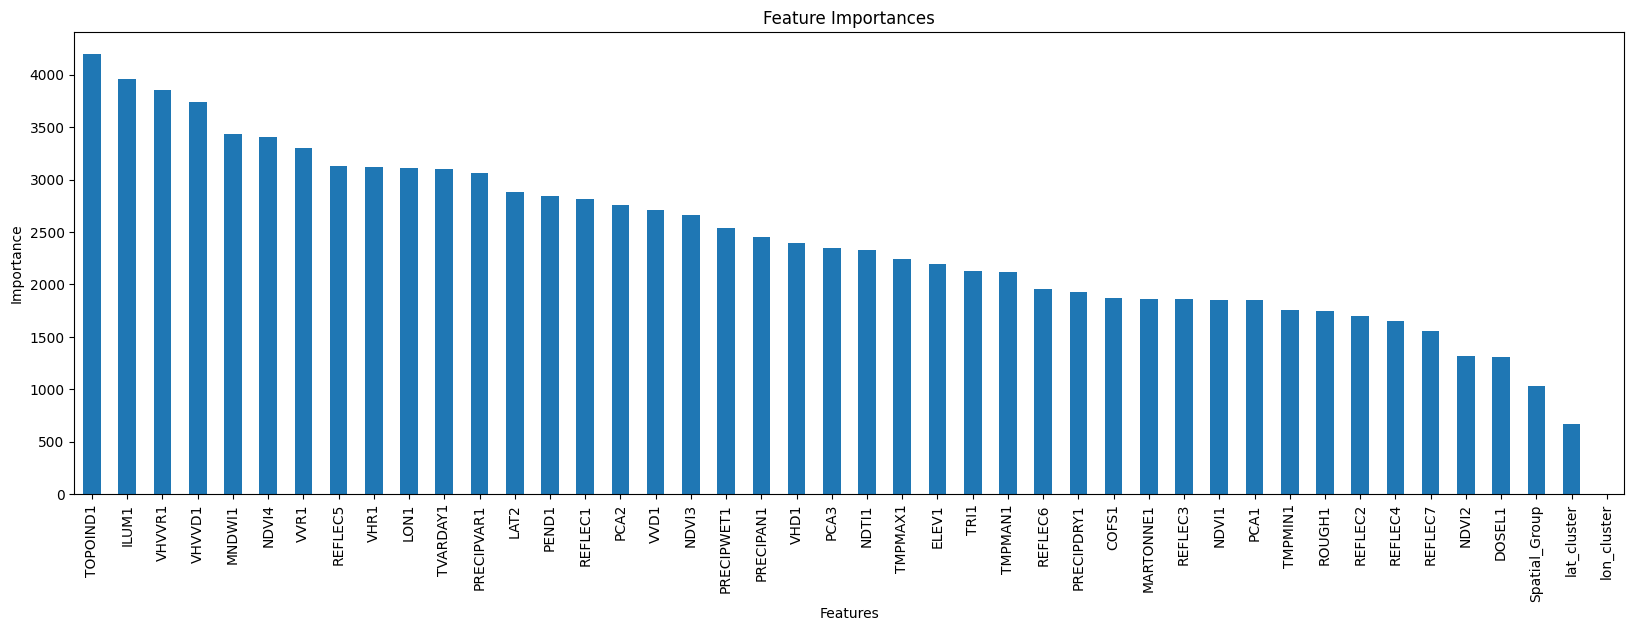

In [61]:
importances = model.feature_importances_
names = model.feature_name_
fi = pd.DataFrame({'Feature': names,
                   'importances': importances})
fi = fi.sort_values(by='importances', ascending=False)

fi.plot(kind='bar', x='Feature', y='importances', legend=False, figsize=(20, 6))
plt.title('Feature Importances')
plt.xlabel('Features')
plt.ylabel('Importance')
plt.show()